# Transposases

In [1]:
# A lot of this is not used, but we import it so we have it later!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from PhiSpyAnalysis import theils_u, DateConverter, file_to_accession

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA


import subprocess
import gzip

# this is a neat trick for getting markdown in our output
# see https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole
# for the inspiration
from IPython.display import Markdown, display
def printmd(string, color="black"):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [2]:
use_small_data=False

In [3]:
if use_small_data:
    checkv = pd.read_csv("../small_data/checkv.tsv.gz", compression='gzip', header=0, delimiter="\t")
else:
    checkv = pd.read_csv("../data/checkv.tsv.gz", compression='gzip', header=0, delimiter="\t")
checkv = checkv.rename(columns={"BASE": "Contig", 'contig_id': 'phage'})
checkv

,Contig,phage,contig_length,gene_count,viral_genes,host_genes,checkv_quality,miuvig_quality,completeness
0,GCA_000003135.1_ASM313v1_genomic.gbff.gz,GG666849.1_PP1,20352,30,0,2,Not-determined,Genome-fragment,NaN
1,GCA_000003135.1_ASM313v1_genomic.gbff.gz,GG666854.1_PP2,28564,28,1,14,Low-quality,Genome-fragment,35.35
2,GCA_000003645.1_ASM364v1_genomic.gbff.gz,CM000714.1_PP1,40297,55,14,9,Medium-quality,Genome-fragment,53.01
3,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP1,21020,21,0,21,Not-determined,Genome-fragment,NaN
4,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP2,17449,20,1,12,Low-quality,Genome-fragment,9.46
...,...,...,...,...,...,...,...,...,...
1094260,GCA_011445755.1_PDT000053321.2_genomic.gbff.gz,AAQAOR010000025.1_PP3,2331,4,0,0,Not-determined,Genome-fragment,NaN
1094261,GCA_011445755.1_PDT000053321.2_genomic.gbff.gz,AAQAOR010000028.1_PP4,23624,27,15,2,Medium-quality,Genome-fragment,50.94
1094262,GCA_011445755.1_PDT000053321.2_genomic.gbff.gz,AAQAOR010000029.1_PP5,6567,6,6,0,Low-quality,Genome-fragment,18.65
1094263,GCA_011445755.1_PDT000053321.2_genomic.gbff.gz,AAQAOR010000032.1_PP6,18522,13,0,7,Not-determined,Genome-fragment,NaN


In [4]:
tns = pd.read_csv("../data/transposase_counts.tsv.gz", compression='gzip', header=0, delimiter="\t")
tns

,phage,transpoase
0,AAEWSU010000037.1_PP9,1
1,AAIOSE010000040.1_PP10,1
2,NWSB01000019.1_PP4,1
3,VDFC01000058.1_PP22,1
4,AAAAIU010000025.1_PP3,1
...,...,...
540329,AAOTBO010000062.1_PP5,1
540330,CP013688.1_PP3,2
540331,AAPBQK010000001.1_PP2,1
540332,AAJACB010000041.1_PP3,1


In [5]:
tns = tns.drop(tns[tns['transpoase'] > 50].index)

In [6]:
tncv = pd.merge(checkv, tns, left_on='phage', right_on='phage', how='inner')
tncv

,Contig,phage,contig_length,gene_count,viral_genes,host_genes,checkv_quality,miuvig_quality,completeness,transpoase
0,GCA_000003645.1_ASM364v1_genomic.gbff.gz,CM000714.1_PP1,40297,55,14,9,Medium-quality,Genome-fragment,53.01,2
1,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP3,67074,80,2,22,High-quality,High-quality,100.00,5
2,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP4,79454,82,2,10,Medium-quality,Genome-fragment,89.94,4
3,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP5,30904,43,0,10,Not-determined,Genome-fragment,NaN,2
4,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP6,52180,75,5,12,Low-quality,Genome-fragment,35.80,5
...,...,...,...,...,...,...,...,...,...,...
177421,GCA_011445715.1_PDT000059787.2_genomic.gbff.gz,AAQAPQ010000014.1_PP4,9973,17,0,0,Not-determined,Genome-fragment,NaN,1
177422,GCA_011445715.1_PDT000059787.2_genomic.gbff.gz,AAQAPQ010000042.1_PP6,35930,45,32,1,Medium-quality,Genome-fragment,78.23,1
177423,GCA_011445735.1_PDT000042966.4_genomic.gbff.gz,AAQAOI010000011.1_PP2,10192,11,0,2,Not-determined,Genome-fragment,NaN,1
177424,GCA_011445755.1_PDT000053321.2_genomic.gbff.gz,AAQAOR010000004.1_PP1,12126,16,3,2,Low-quality,Genome-fragment,9.03,1


<AxesSubplot:xlabel='checkv_quality', ylabel='transpoase'>

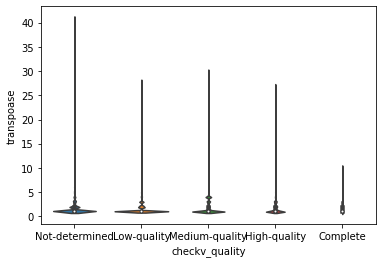

In [7]:
sns.violinplot(x='checkv_quality', y='transpoase', data=tncv, scale='count', order=['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality', 'Complete'])

<AxesSubplot:xlabel='checkv_quality', ylabel='transpoase'>

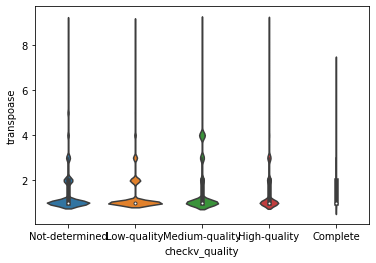

In [8]:
sns.violinplot(x='checkv_quality', y='transpoase', data=tncv[tncv['transpoase'] < 10], scale='count', order=['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality', 'Complete'])

<AxesSubplot:xlabel='contig_length', ylabel='transpoase'>

c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


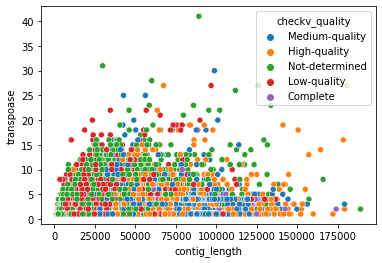

In [9]:
sns.scatterplot(x='contig_length', y='transpoase', data=tncv, hue='checkv_quality')

<AxesSubplot:xlabel='contig_length', ylabel='transpoase'>

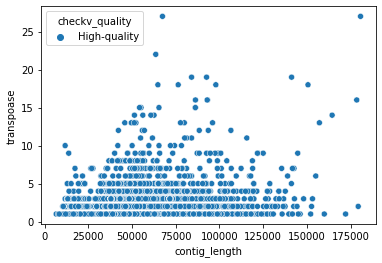

In [10]:
#sns.scatterplot(x='contig_length', y='transpoase', data=tncv[tncv['checkv_quality'] == 'Complete'], hue='checkv_quality')
sns.scatterplot(x='contig_length', y='transpoase', data=tncv[tncv['checkv_quality'] == 'High-quality'], hue='checkv_quality')

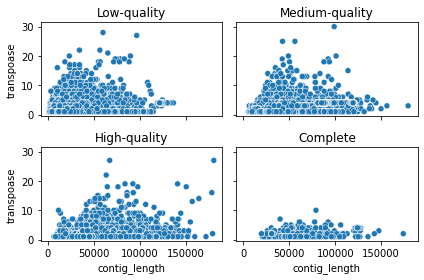

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
d = [['Low-quality', 'Medium-quality'], ['High-quality', 'Complete']]
x = 'contig_length'
for i in 0, 1:
    for j in 0, 1:
        sns.scatterplot(x=x, y='transpoase', data=tncv[tncv['checkv_quality'] == d[i][j]], hue='checkv_quality', ax=ax[i][j], legend=False)
        ax[i][j].set_title(d[i][j])
plt.tight_layout()
plt.show()
        

In [12]:
tncv[(tncv['checkv_quality'] == 'Low-quality') & (tncv['transpoase'] > 75)]

,Contig,phage,contig_length,gene_count,viral_genes,host_genes,checkv_quality,miuvig_quality,completeness,transpoase


In [13]:
tncv.drop(38935)

,Contig,phage,contig_length,gene_count,viral_genes,host_genes,checkv_quality,miuvig_quality,completeness,transpoase
0,GCA_000003645.1_ASM364v1_genomic.gbff.gz,CM000714.1_PP1,40297,55,14,9,Medium-quality,Genome-fragment,53.01,2
1,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP3,67074,80,2,22,High-quality,High-quality,100.00,5
2,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP4,79454,82,2,10,Medium-quality,Genome-fragment,89.94,4
3,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP5,30904,43,0,10,Not-determined,Genome-fragment,NaN,2
4,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP6,52180,75,5,12,Low-quality,Genome-fragment,35.80,5
...,...,...,...,...,...,...,...,...,...,...
177421,GCA_011445715.1_PDT000059787.2_genomic.gbff.gz,AAQAPQ010000014.1_PP4,9973,17,0,0,Not-determined,Genome-fragment,NaN,1
177422,GCA_011445715.1_PDT000059787.2_genomic.gbff.gz,AAQAPQ010000042.1_PP6,35930,45,32,1,Medium-quality,Genome-fragment,78.23,1
177423,GCA_011445735.1_PDT000042966.4_genomic.gbff.gz,AAQAOI010000011.1_PP2,10192,11,0,2,Not-determined,Genome-fragment,NaN,1
177424,GCA_011445755.1_PDT000053321.2_genomic.gbff.gz,AAQAOR010000004.1_PP1,12126,16,3,2,Low-quality,Genome-fragment,9.03,1


<AxesSubplot:xlabel='gene_count', ylabel='transpoase'>

c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


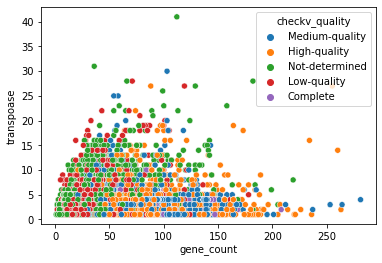

In [14]:
sns.scatterplot(x='gene_count', y='transpoase', data=tncv, hue='checkv_quality')

In [15]:
tncv.dtypes

Contig             object
phage              object
contig_length       int64
gene_count          int64
viral_genes         int64
host_genes          int64
checkv_quality     object
miuvig_quality     object
completeness      float64
transpoase          int64
dtype: object

<AxesSubplot:xlabel='completeness', ylabel='transpoase'>

c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


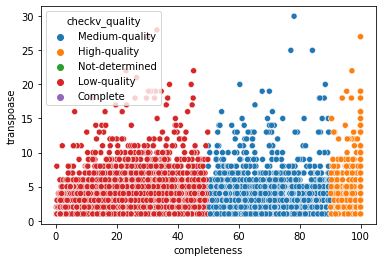

In [16]:
ho=['Medium-quality', 'High-quality']
sns.scatterplot(x='completeness', y='transpoase', data=tncv, hue='checkv_quality')
#, hue_order=['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality'])

<AxesSubplot:xlabel='host_genes', ylabel='transpoase'>

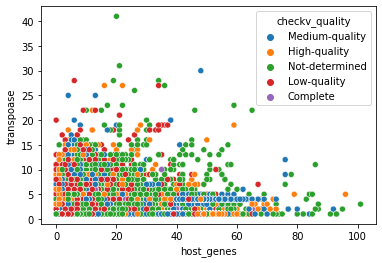

In [17]:
sns.scatterplot(x='host_genes', y='transpoase', data=tncv, hue='checkv_quality')